In [1]:
import os, glob
os.environ['CUDA_VISIBLE_DEVICES'] = '1'


from pytorch_lightning import utilities as pl_utils
from pytorch_lightning.trainer.trainer import Trainer
from pytorch_lightning.plugins import DDPPlugin
import torch
import torch.nn as nn
import pathlib
import sys
import numpy as np

sys.path.append('..')
sys.path.append('../deep-learning-base')
sys.path.append('../deep-learning-base/training')
sys.path.append('../partially_inverted_reps')

import plot_helper as plt_hp
import output as out
import architectures as arch
from architectures.callbacks import LightningWrapper
from datasets.data_modules import DATA_MODULES
import datasets.dataset_metadata as dsmd
from partial_loss import PartialInversionLoss, PartialInversionRegularizedLoss
from __init__ import DATA_PATH_IMAGENET, DATA_PATH, SERVER_PROJECT_PATH
from functools import partial
import stir.model.tools.helpers as helpers
import stir
import itertools

/NS/twitter_archive2/work/vnanda/minconda3/envs/dl_base/lib/python3.7/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
EVAL_DATASETS = ['imagenet', 'cifar10', 'cifar100', 'flowers', 'oxford-iiit-pets']

CHECKPOINT_PATHS = {
    'resnet50': {
        'nonrob': '',
        'robustl2eps3': \
            '/NS/robustness_3/work/vnanda/adv-robustness/logs/robust_imagenet/eps3/resnet-50-l2-eps3.ckpt'
        },
    'resnet50_mrl': {
        'nonrob': '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/checkpoints'\
                  '/imagenet1k/r50_mrl1_e0_ff2048.pt'
    },
    'vit_small_patch16_224': {
        'nonrob': \
            '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/checkpoints/imagenet21k/'\
            'S_16-i21k-300ep-lr_0.001-aug_light1-wd_0.03-do_0.0-sd_0.0.npz'
        },
    'vit_small_patch32_224': {
        'nonrob': \
            '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/checkpoints/imagenet21k/'\
            'S_32-i21k-300ep-lr_0.001-aug_light1-wd_0.03-do_0.0-sd_0.0.npz'
        },
}
SEED = 2
BATCH_SIZE = 100

In [3]:
class MaskedModel(nn.Module):
    def __init__(self, model, mask):
        super().__init__()
        self.mask = mask
        self.model = model
    
    def forward(self, x, *args, **kwargs):
        out, latent = self.model(x, *args, **kwargs)
        return out, latent[:,self.mask]

In [4]:
def find_chosen_neurons(m1, mode, seeds, numbers):
    frac_to_chosen_neurons = {}
    name, param = list(m1.model.named_modules())[-1]
    in_fts = param.in_features
    if mode == 'random':
        for partial_seed in seeds:
            for num_neurons in numbers:
                linear = nn.Linear(num_neurons, dsmd.DATASET_PARAMS[SOURCE_DATASET]['num_classes'])
                torch.manual_seed(partial_seed)
                chosen_neurons = torch.randperm(in_fts)[:num_neurons]
                if num_neurons in frac_to_chosen_neurons:
                    frac_to_chosen_neurons[num_neurons].append(chosen_neurons)
                else:
                    frac_to_chosen_neurons[num_neurons] = [chosen_neurons]
    elif mode == 'first':
        for num_neurons in numbers:
            chosen_neurons = torch.arange(in_fts)[:num_neurons]
            if num_neurons in frac_to_chosen_neurons:
                frac_to_chosen_neurons[num_neurons].append(chosen_neurons)
            else:
                frac_to_chosen_neurons[num_neurons] = [chosen_neurons]
    return frac_to_chosen_neurons

In [18]:
def results(SOURCE_DATASET, MODEL, APPENDS, PARTIAL_CHOICE_SEEDS, NUMBERS, MODE):
    results = []
    for eval_ds in EVAL_DATASETS:
        print (eval_ds)
        append_to_frac_ckas = {}
        dm = DATA_MODULES[eval_ds](
            data_dir=DATA_PATH_IMAGENET if 'imagenet' in eval_ds else DATA_PATH,
            transform_train=dsmd.TEST_TRANSFORMS_DEFAULT(224),
            transform_test=dsmd.TEST_TRANSFORMS_DEFAULT(224),
            batch_size=BATCH_SIZE)
        dm.init_remaining_attrs(eval_ds)
        for append in APPENDS:
            m1 = arch.create_model(MODEL, SOURCE_DATASET, pretrained=True,
                                   checkpoint_path=CHECKPOINT_PATHS[MODEL][append], seed=SEED, 
                                   callback=partial(LightningWrapper, 
                                                    dataset_name=SOURCE_DATASET,
                                                    inference_kwargs={'with_latent': True}),
                                  loading_function_kwargs={'strict': False} \
                                   if MODEL == 'resnet50_mrl' else {})
            frac_to_chosen_neurons = find_chosen_neurons(m1, MODE, PARTIAL_CHOICE_SEEDS, NUMBERS)
            frac_to_ckas = {}
            for num_neurons in NUMBERS[:-1]: # last one is full layer
                full_mask = frac_to_chosen_neurons[NUMBERS[-1]]
                for mask1, mask2 in itertools.product(frac_to_chosen_neurons[num_neurons], full_mask):
                    stir_score = stir.STIR(MaskedModel(m1, mask1), MaskedModel(m1, mask2), 
                        helpers.InputNormalize(dsmd.STANDARD_MEAN, dsmd.STANDARD_STD), 
                        helpers.InputNormalize(dsmd.STANDARD_MEAN, dsmd.STANDARD_STD),
                        (dm.test_dataloader(), 1000), verbose=False, layer1_num=None, 
                        layer2_num=None, no_opt=True, cka_only=True)
                    if num_neurons in frac_to_ckas:
                        frac_to_ckas[num_neurons].append(stir_score.rsm)
                    else:
                        frac_to_ckas[num_neurons] = [stir_score.rsm]

            append_to_frac_ckas[append] = frac_to_ckas
        results.append(append_to_frac_ckas)
    
    plt_str = '== CKA Analysis between part and whole layer ==\n\n'
    for idx, eval_ds in enumerate(EVAL_DATASETS):
        plt_str += f'=== {eval_ds} ===\n\n'
        for append in APPENDS:
            frac_to_ckas = results[idx][append]
            x_vals, y_vals = list(zip(*sorted(frac_to_ckas.items(), key=lambda t: t[0])))
            plt_str += '== {} ==\n\n{}\n\n'.format(
                append,
                plt_hp.get_wiki_link(plt_hp.line_plot(
                    [[np.mean(_y) for _y in y_vals]], 'Number of Neurons', 
                    'CKA between fraction and full', f'Eval On {eval_ds}, mode = {MODE}', 
                    subfolder=SOURCE_DATASET, filename=f'part-whole-{MODEL}-{append}-{eval_ds}-{MODE}', 
                    extension='png', x_vals=x_vals, 
                    legend_vals=['CKA (fraction, full)'], vertical_line=None, 
                    colors=None, linestyles=['-', '--'],
                    y_lims=(0.,1.1), root_dir='.', paper_friendly_plots=False, 
                    plot_inside=False, legend_location='best', savefig=True, figsize=(10,6), 
                    marker=[True], results_subfolder_name='cka_analysis_part_whole', 
                    grid_spacing=None, y_err=[[np.std(_y) for _y in y_vals]], legend_ncol=None), 
                                     SERVER_PROJECT_PATH, size=700))
    
    with open(f'./results/cka_analysis_part_whole/{SOURCE_DATASET}/'
              f'wiki_results-{MODEL}-{MODE}.txt', 'w') as fp:
        fp.write(plt_str)

    out.upload_results(['{}/{}/{}'.format(plt_hp.RESULTS_FOLDER_NAME, 
                                          'cka_analysis_part_whole', SOURCE_DATASET)], 
            'results', SERVER_PROJECT_PATH, '.png')
    return results

In [ ]:
SOURCE_DATASET = 'imagenet'
MODEL = 'resnet50_mrl'
APPENDS = list(CHECKPOINT_PATHS[MODEL].keys())
NUMBERS = [8,16,32,64,128,256,512,1024,2048]
SEEDS = list(range(1,6))

resnet50_mrl_first = results(SOURCE_DATASET, MODEL, APPENDS, [], NUMBERS, 'first')
resnet50_mrl_random = results(SOURCE_DATASET, MODEL, APPENDS, SEEDS, NUMBERS, 'random')

Global seed set to 2


imagenet


No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 0


In [ ]:
SOURCE_DATASET = 'imagenet'
MODEL = 'resnet50'
APPENDS = list(CHECKPOINT_PATHS[MODEL].keys())
NUMBERS = [8,16,32,64,128,256,512,1024,2048]
FRACTIONS = [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 0.9, 1.]
SEEDS = list(range(1,6))

resnet50_numbers = results(SOURCE_DATASET, MODEL, APPENDS, SEEDS, NUMBERS, 'random')
resnet50_fracs = results(SOURCE_DATASET, MODEL, APPENDS, SEEDS, 
                         [int(x * NUMBERS[-1]) for x in FRACTIONS], 'random')

Global seed set to 2


imagenet


Global seed set to 0


In [ ]:
resnet50_numbers_test = results(SOURCE_DATASET, MODEL, APPENDS, SEEDS, NUMBERS, 'random')
resnet50_fracs_test = results(SOURCE_DATASET, MODEL, APPENDS, SEEDS, 
                         [int(x * NUMBERS[-1]) for x in FRACTIONS], 'random')

Global seed set to 2


imagenet


Global seed set to 0
Global seed set to 2


In [25]:
resnet50_fracs[0]['robustl2eps3']

{1: [0.18609687685966492,
  0.15652282536029816,
  0.14270630478858948,
  0.12533977627754211,
  0.1733003705739975,
  0.1202581375837326,
  0.15010039508342743,
  0.11295165866613388,
  0.13050223886966705,
  0.09650488942861557,
  0.11140100657939911,
  0.1076277494430542,
  0.136764258146286,
  0.10922545194625854,
  0.09554699808359146,
  0.1254381239414215,
  0.11334199458360672,
  0.1185428723692894,
  0.1142093688249588,
  0.10807057470083237,
  0.12903138995170593,
  0.12252406775951385,
  0.15074467658996582,
  0.10720022022724152,
  0.15666940808296204],
 2: [0.20143568515777588,
  0.20774665474891663,
  0.20864255726337433,
  0.22574816644191742,
  0.18407075107097626,
  0.21347975730895996,
  0.19643613696098328,
  0.2388789802789688,
  0.22890155017375946,
  0.21373288333415985,
  0.16332772374153137,
  0.19625301659107208,
  0.18814897537231445,
  0.16948209702968597,
  0.20151591300964355,
  0.1814754754304886,
  0.16234523057937622,
  0.15905147790908813,
  0.1667951345

../plot_helper.py:119: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  linestyle=linestyles[i] if linestyles is not None else '-',


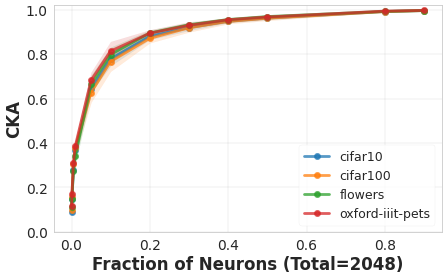

../plot_helper.py:119: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  linestyle=linestyles[i] if linestyles is not None else '-',


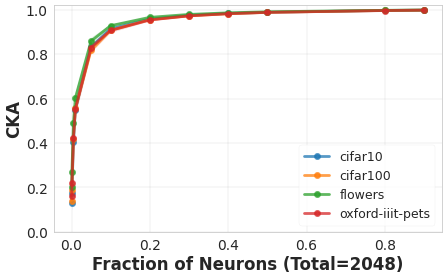

In [23]:
for append in CHECKPOINT_PATHS['resnet50'].keys():
    all_x_vals, all_y_vals, all_full_accs = [], [], []
    for idx, ft_ds in enumerate(EVAL_DATASETS[1:]):
        x, y = list(zip(*sorted(
            resnet50_fracs_test[idx+1][append].items(), key=lambda i:i[0])))
        all_x_vals.append([x_/NUMBERS[-1] for x_ in x])
        all_y_vals.append(y)
    plt_hp.line_plot(
        [[np.mean(_y) for _y in y_vals] for y_vals in all_y_vals], 
        'Fraction of Neurons (Total=2048)', 'CKA', '', 
        subfolder=SOURCE_DATASET, filename=f'part-whole-{MODEL}-{append}-allds-random_test', 
        extension='png', x_vals=all_x_vals, legend_vals=EVAL_DATASETS[1:], vertical_line=None, 
        colors=plt_hp.COLORS[:len(EVAL_DATASETS)], 
        linestyles=['-']*len(EVAL_DATASETS), 
        y_lims=(0.,1.02), root_dir='.', paper_friendly_plots=True, 
        plot_inside=True, legend_location='lower right', savefig=True, figsize=(10,6), 
        marker=[True] * len(EVAL_DATASETS), 
        results_subfolder_name='cka_analysis_part_whole', grid_spacing=None, 
        y_err=[[np.std(_y) for _y in y_vals] for y_vals in all_y_vals], legend_ncol=None)

In [ ]:
SOURCE_DATASET = 'imagenet21k'
MODEL = 'vit_small_patch16_224'
APPENDS = list(CHECKPOINT_PATHS[MODEL].keys())
NUMBERS = [2,5,11,23,47,95,191,382,764]
SEEDS = list(range(1,6))

results(SOURCE_DATASET, MODEL, APPENDS, SEEDS, NUMBERS, 'random')

In [ ]:
SOURCE_DATASET = 'imagenet21k'
MODEL = 'vit_small_patch32_224'
APPENDS = list(CHECKPOINT_PATHS[MODEL].keys())
NUMBERS = [2,5,11,23,47,95,191,382,764]
SEEDS = list(range(1,6))

results(SOURCE_DATASET, MODEL, APPENDS, SEEDS, NUMBERS, 'random')